# Project 2 - Community detection in an academic network
## Aim
<ol>
  <li> Load social graph</li>
  <li> Run community detection and centrality methods</li>
  <li> Visualize the network </li>
</ol>

## Tasks
<ol>
    <li> <strong>Load the dataset:</strong> Load the Author Network dataset provided in <a href:"https://aminer.org/lab-datasets/soinf/">https://aminer.org/lab-datasets/soinf/</a>
The graph consists of authors and coauthor relationships.
  </li>
    <li> <strong>Implementation:</strong> 
        <ol>
            <li> Implement Girvan-Newman clustering algorithm till 10th iteration level.</li>
            <li> Implement Pagerank algorithm.</li>
            <li> Implement Betweenness centrality measure</li>        
        </ol>
        Use the previous implementation, perform the following tasks
        <ol>
            <li> Use Girvan-Newman algorithm to find clusters of authors</li>
            <li> Find the top-10 authors with highest betweenness centrality</li>      
        </ol>
    </li>
    <li> <strong>Visualization: </strong> 
        <ol>
            <li> Visualize the output of Girvan-Newman algorithm by coloring nodes ccording to their assigned groups</li>
            <li> Visualize the network and highlight the top 10 authors with the highest betweeness centrality and top 10 edges with the highest betweenness centrality</li>      
        </ol>
    </li>


# 1. Load the dataset

In [19]:
# Import Modules
import networkx as nx
from pprint import pprint
import operator
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import math
import random

# Utility class to pretty print dictionary
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for key, value in iter(self.items()):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(str(len(value))+" "+"graph[s] of size: "+str([len(x) for x in value])+" nodes"))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
print("> All necessary modules imported")

> All necessary modules imported


In [20]:
# Load Data
DATASET = "./data"

def loadData(directoryPath):
    """Load the data of all files of the folder given in parameter."""
    files = os.listdir(directoryPath)
    # dictionary wrt to the following format: {topic1:[[network1],[network2]]}
    allGraphsOfEachTopic = {}
    for file in files:
        topic = ""
        if "T16" in file:
            topic = "Data Mining/Association Rules"
        elif "T107" in file:
            topic = "Web Services"
        elif "T131" in file:
            topic = "Bayesian Networks/Belief function"
        elif "T144" in file:
            topic = "Web Mining/Information Fusion"
        elif "T145" in file:
            topic = "Semantic Web/Description Logics"
        elif "T162" in file:
            topic = "Machine Learning"
        elif "T24" in file:
            topic = "Database Systems/XML Data"
        elif "T75" in file:
            topic = "Information Retrieval"
        else:
            topic = "Unknown"

        graphToBuild = nx.Graph()
        graphToBuild.name = topic.replace('/', ' ').replace(' ', '')

        # constant
        VERTEX = 0
        EDGE = 1
        TRIANGLE = 2

        f = open(DATASET+"/"+file)

        # Vertices: Int "String" Int -> NodeID, personName, #papers
        # Edges: Int Int Int -> sourceNodeID, DestNodeID, #coauthoredPapers
        # Triangles: Int,Int,Int,Int -> NodeID1, NodeID2, NodeID3, #coauthoredPapers
        for line in f:
            if "*Vertices" in line:
                typeOfLine = VERTEX
            elif "*Edges" in line:
                typeOfLine = EDGE
            elif "*Triangles" in line:
                typeOfLine = TRIANGLE
            else:
                if typeOfLine == VERTEX:
                    graph_edge_list = [s.replace(' ','') for s in re.split('"', line)]
                    graphToBuild.add_node(graph_edge_list[0], name=graph_edge_list[1], nbpapers=graph_edge_list[2])
                elif typeOfLine == EDGE:
                    graph_edge_list = line.split()
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapers=graph_edge_list[2])
                elif typeOfLine == TRIANGLE:
                    graph_edge_list = line.split(',')
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[1], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])

        if topic in allGraphsOfEachTopic:
            allGraphsOfEachTopic[topic].append(graphToBuild)
        else:
            allGraphsOfEachTopic[topic] = [graphToBuild]

    return allGraphsOfEachTopic

allData = loadData(DATASET)
print("> All data loaded")
DictTable(allData)


> All data loaded


{'Web Services': [<networkx.classes.graph.Graph at 0x22c96c82518>,
  <networkx.classes.graph.Graph at 0x22c9961ba58>],
 'Bayesian Networks/Belief function': [<networkx.classes.graph.Graph at 0x22c9f994588>],
 'Web Mining/Information Fusion': [<networkx.classes.graph.Graph at 0x22c9f0af4a8>,
  <networkx.classes.graph.Graph at 0x22c9eca8780>,
  <networkx.classes.graph.Graph at 0x22ca7765d30>],
 'Semantic Web/Description Logics': [<networkx.classes.graph.Graph at 0x22ca7772160>,
  <networkx.classes.graph.Graph at 0x22c9ae21eb8>],
 'Data Mining/Association Rules': [<networkx.classes.graph.Graph at 0x22c9eb8abe0>,
  <networkx.classes.graph.Graph at 0x22c9aab2908>],
 'Database Systems/XML Data': [<networkx.classes.graph.Graph at 0x22c98c7ea20>],
 'Information Retrieval': [<networkx.classes.graph.Graph at 0x22ca1ff3cf8>,
  <networkx.classes.graph.Graph at 0x22c98ee4b00>]}

# 2. Implementation
## Implementation of the betweenness centrality measure

In [31]:
def edgesBetweenessCentrality(allShortestPath, edge):
    """computes the betweenness centrality of a given edge"""
    # Initialization of variables to compute centrality of each edge
    centrality=0
    nbPathsIncludingEdge=0
    counterShortestPath=0
            
    # For all shortestPath, count the number of them that contain the current edge 
    for vi in allShortestPath:
        for vj in vi[1]:
            nbPathsIncludingEdge += edgeIsInPath([edge[0], edge[1]], vi[1][vj])
            counterShortestPath+=1
            
    # Centrality = Number of shortest paths including the edge / total number of shortest paths       
    centrality += nbPathsIncludingEdge / counterShortestPath
    return centrality

def edgeIsInPath(edge, path):
    """checks if an edge is contained in a path of an undirected graph (the path is a list of nodes)"""
    edge1= [edge[0],edge[1]]
    edge2= [edge[1],edge[0]]
    if all(i in path for i in edge1) or all(i in path for i in edge2):
        return 1
    else:
        return 0
    
def nodesBetweennessCentrality(graph, node):
    """betweenness centrality of a given node: not used in this project but implemented for fun"""
    centrality = 0
    nodes = list(graph.nodes())
    for vi in range(len(nodes)-1):
        for vj in range(vi+1, len(nodes)):
            if(nodes[vi] == node or nodes[vj] == node):
                continue

            shortestPaths = list(nx.all_shortest_paths(graph, source=nodes[vi], target=nodes[vj]))
            nbPathsIncludingNode = sum(path.count(node) for path in shortestPaths)
            centrality += nbPathsIncludingNode / len(shortestPaths)
    return centrality

## Implementation of visualizations used in Girvan-Newman clustering (see next cell)

In [32]:
def drawGraph(G):
    """draws the given graph and displays the labels of each edge"""
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos)
    plt.show()

def drawGraphs(G, cnt):
    """Draw all different subgraphs on the same picture"""
    test = plt.subplot(4, 3, cnt)
    if (cnt == 1):
        test.title.set_text('Initial state of the graph')
    else:
        test.title.set_text('State of the graph at iteration: {}, number of communities: {}'.format(cnt-1, nx.number_connected_components(G)))
    test.set_yticklabels([])
    test.set_xticklabels([])
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos)
    nx.draw_networkx_edge_labels(G, pos)

def drawColoredGraph(G):
    """# draws a graph where communities are drawn using different colors"""
    test = plt.subplot(4,3,12)
    test.set_yticklabels([])
    test.set_xticklabels([])
    test.title.set_text('Resulting communities ({})'.format(nx.number_connected_components(G)))
    pos = nx.spring_layout(G)
    connected_components = nx.connected_component_subgraphs(G)
    for index, sg in enumerate(connected_components):
        r = lambda: random.randint(0,255)
        randomColor =('#%02X%02X%02X' % (r(),r(),r()))
        nx.draw_networkx(sg, pos = pos, node_color = str(randomColor), with_labels= False, edgelist=[])

## Implementation of Girvan-Newman(2, optimized) clustering till 10th iteration level

Iteration n°:  10
Iteration n°:  9
Iteration n°:  8
Iteration n°:  7
Iteration n°:  6
Iteration n°:  5
Iteration n°:  4
Iteration n°:  3
Iteration n°:  2
Iteration n°:  1


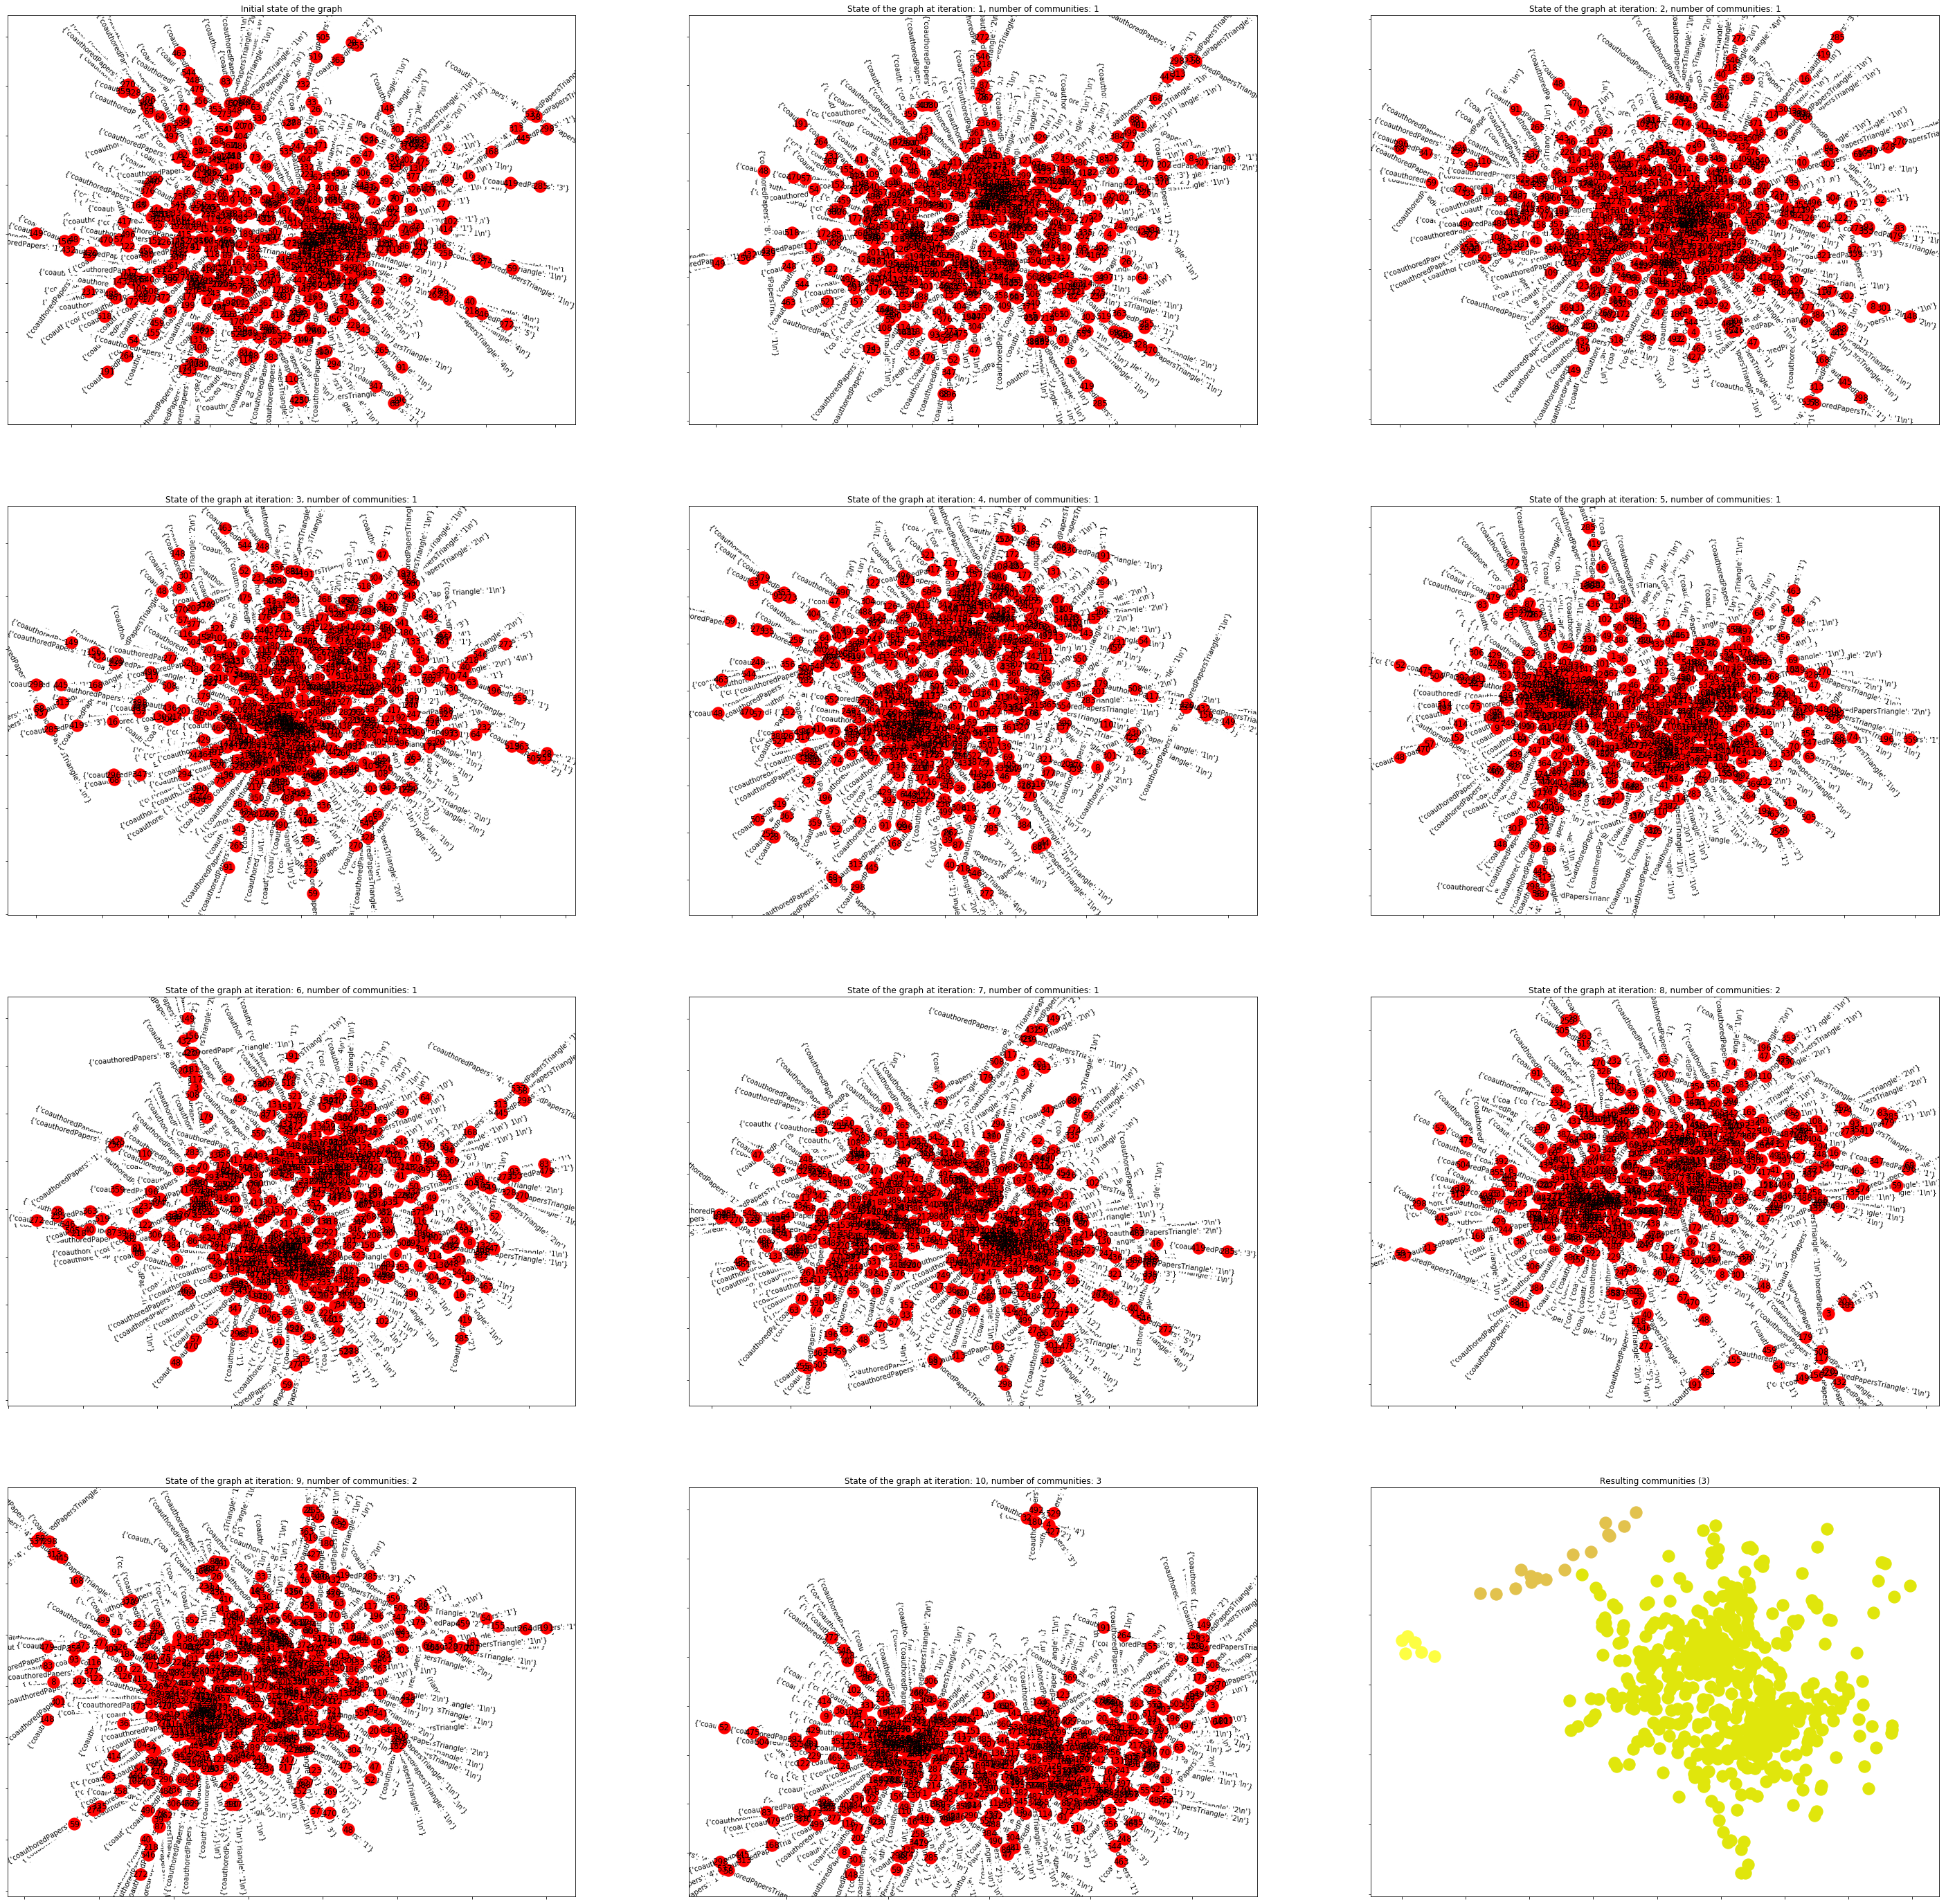

In [34]:
def girvanNewmanClustering(graph, nbIteration):
    
    # Draw first plot in figure and use variable cnt to handle positions
    fig = plt.figure(figsize=(50, 50))
    drawGraphs(graph, 1)
    cnt = 2
    
    # If there are no edge in the graph
    if len(list(graph.edges)) == 0:
        return "Empty graph"

    # While there are edges in the graph and that the number of iteration is biggger than 0
    while(len(list(graph.edges)) > 0 and nbIteration > 0):
        print("Iteration n°: ", nbIteration)
        nbIteration = nbIteration - 1
        
        # Compute all shortest path between all nodes,transform this into a numpy array, put 0 at each element
        # under the diagonal of the matrix
        allShortestPath = np.triu(np.asarray(list(nx.all_pairs_shortest_path(graph))),-2)
        
        # Delete all rows containging only 0
        allShortestPath = allShortestPath[~np.all(allShortestPath == 0, axis=1)]
        
        # Get all edges of the current graph
        edges = np.asarray(list(graph.edges))
        
        # Variable to store the highest edge and the centrality associated with it
        highestEdge = ""
        highestScore = -float('inf')
        
        for edge in edges:
            
            centrality = edgesBetweenessCentrality(allShortestPath,edge)
            # Keep the edge with the highest centrality
            if centrality > highestScore:
                highestScore = centrality
                highestEdge = edge
                
        # Remove the edge with the highest centrality
        graph.remove_edge(highestEdge[0], highestEdge[1])
        
        # Draw the graph with the removed edge into the figure
        drawGraphs(graph, cnt)
        cnt += 1
        
    # Draw the original graph with colors to detect communities and save the figure
    print("Drawing...")
    drawColoredGraph(graph)
    print("Drawing done")
    plt.savefig("./Figures/GirvanNewman/{}.png".format(graph.name))
    print("> Figure saved)
                

#graph = allData['Database Systems/XML Data'][0].copy()
#graph = allData["Information Retrieval"][1].copy()
#graph = allData["Data Mining/Association Rules"][0].copy()
graph = allData["Bayesian Networks/Belief function"][0].copy()
girvanNewmanClustering(graph, 10)

## Implementation of Pagerank algorithm

In [11]:
def pageRankCentrality(graph, alpha, beta):
    # Transposition of matrix
    adjacencyMatrix = nx.to_numpy_matrix(graph, weight='None')
    amTransposed = np.transpose(adjacencyMatrix)

    # Diagonal Matrix
    diagonalMatrix = np.zeros([adjacencyMatrix.shape[0], adjacencyMatrix.shape[1]])
    row, col = np.diag_indices(diagonalMatrix.shape[0])
    # Compute the values that have to be filled into the diagonal
    diagonalMatrix[row, col] = [1 / degree[1] for degree in list(graph.degree())]

    # Identity matrix
    identityMatrix = np.identity(adjacencyMatrix.shape[0])

    # Vector of ones
    ones = np.ones((adjacencyMatrix.shape[0], 1))
    pageRankCentrality = np.dot(beta * np.linalg.inv((identityMatrix - np.dot(alpha * amTransposed, diagonalMatrix))), ones)

    return pageRankCentrality

